In [1]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm
import matplotlib.pyplot as plt
from metpy.units import units

import datetime as dt
from sklearn.metrics import r2_score
from metpy.units import units
import math 
import geopandas as gpd

In [2]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20

data_start_date = '20221107'
data_cutoff_date = '20230619'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
sos_tidy_fn = f"process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

# Open data

## SOS

In [3]:
tidy_df = pd.read_parquet(sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df[tidy_df.time > data_start_date][tidy_df.time < data_cutoff_date]
tidy_df = tidy_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

In [4]:
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230301':'20230401']))
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230301':'20230401'].dropna()))

1534
1513


In [5]:
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230401':'20230501']))
print(len(tidy_df.query("variable == 'T_3m_c'").set_index('time').loc['20230401':'20230501'].dropna()))

1488
1488


In [6]:
src = tidy_df.query(f"variable == 'dir_3m_c'")['value'].dropna()
pd.cut(
    src,
    [0,80, 140, 292,332, 360]
).value_counts() / len(src)

value
(292, 332]    0.401163
(332, 360]    0.191579
(80, 140]     0.183046
(0, 80]       0.119655
(140, 292]    0.104557
Name: count, dtype: float64

## SPLASH

In [7]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

# file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]
file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []
abshum_dataarray_list = []
snowdepth_list = []
temp_dataarray_list = []
rh_dataarray_list = []
w_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])
    snowdepth_list.append(dataset['snow_depth'])
    temp_dataarray_list.append(dataset['temp'])  # Add this line
    rh_dataarray_list.append(dataset['rh'])  # Add this line
    w_dataarray_list.append(dataset['wspd_w_mean'])  # Add this line

mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')
annex_snowdepth_ds = xr.concat(snowdepth_list, dim='time')
annex_snowdepth_ds = utils.modify_xarray_timezone(annex_snowdepth_ds, 'UTC', 'US/Mountain')
temp_ds = xr.concat(temp_dataarray_list, dim='time')
temp_ds = utils.modify_xarray_timezone(temp_ds, 'UTC', 'US/Mountain')
rh_ds = xr.concat(rh_dataarray_list, dim='time')
rh_ds = utils.modify_xarray_timezone(rh_ds, 'UTC', 'US/Mountain')
w_ds = xr.concat(w_dataarray_list, dim='time')
w_ds = utils.modify_xarray_timezone(w_ds, 'UTC', 'US/Mountain')

100%|██████████| 646/646 [00:34<00:00, 18.79it/s]


# Create categories

In [8]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values

len(upvalley_wind_times),len(downvalley_wind_times)

(2031, 5441)

In [9]:
print(len(ri_stable_times))
print(len(ri_unstable_times))
print(len(ri_neutral_times))
print(len(tgrad_stable_times))
print(len(tgrad_unstable_times))
print(len(tgrad_neutral_times))

3439
1238
6018
8960
1210
530


# Vertical advection term, 1D numerical solution

## Collect mixing ratio data we need

In [10]:
## Isolate humidity measurements (from hygrometers)
mixing_ratio_profile_df = tidy_df[tidy_df.measurement.isin(['mixing ratio'])]
mixing_ratio_profile_df.measurement = 'q_hygr'
mixing_ratio_profile_df = mixing_ratio_profile_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# Combine with snow depth data
mixing_ratio_profile_df = mixing_ratio_profile_df.melt(ignore_index=False).join(
    tidy_df[tidy_df.variable == 'SnowDepth_c'].set_index('time')['value'].rename('snow depth')
)

# Calculate instrument height above snow surface
mixing_ratio_profile_df['instrument_height'] = mixing_ratio_profile_df['height'] - mixing_ratio_profile_df['snow depth']

# Filter out measurements that are buried in the snow
mixing_ratio_profile_df = mixing_ratio_profile_df[
    (mixing_ratio_profile_df['instrument_height'] > 0)
    | (mixing_ratio_profile_df['height'] == 0)
]

mixing_ratio_profile_df['instrument_height'] = mixing_ratio_profile_df['instrument_height'].where(
    mixing_ratio_profile_df['instrument_height'] > 0,
    0
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/1081983149.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mixing_ratio_profile_df.measurement = 'q_hygr'


## Define function to calculate gradient for a given set of heights and mixingratio measurements (for single timestamp)

In [11]:
from sublimpy.gradients import LogPolynomialWithRoughness

def calculate_mixingratio_gradient(
        one_ts_groupby,
        height4estimate,
        Z0Q = 0.005
    ):
    """ 
    Calculates mixing ratio gradient from a dataframe with datetimeindex,
    and columns `instrument_height`  and `value`, which holds mixing ratio
    values. These calculations are done by fitting log-polynomial curve to 
    measurements of z and X where X is some measured variable.
    We include a boundary wall condition, applying measured X at
    roughness height (T=T_s at z=z0). We also adjust for snow depth 
    in our calculations.
    """    
    heights = one_ts_groupby.sort_values('instrument_height')['instrument_height']
    values = one_ts_groupby.sort_values('instrument_height')['value']

    heights = heights.replace(0,Z0Q)

    # calculate fitted loglinear parameters
    params = LogPolynomialWithRoughness.fit_function(
        values,
        heights
    )
    values_pred = [
        LogPolynomialWithRoughness.function(z, params[0], params[1], params[2])
        for z in heights
    ]
    a = params[0]
    b = params[1]
    gradient = LogPolynomialWithRoughness.gradient_single_component(height4estimate, a, b)
    return gradient, a, b, heights, values, values_pred

## Test the function out

Text(0, 0.5, 'height above snow(m)')

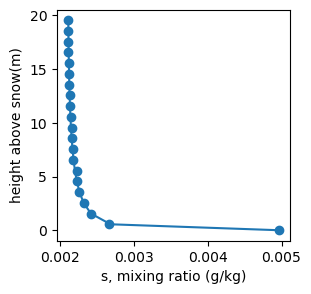

In [12]:
gradient, a, b, heights, values, values_pred =  calculate_mixingratio_gradient(
    mixing_ratio_profile_df.groupby('time').get_group('2023-05-05 12:30:00'),
    3   
)
c = values[0]
plt.figure(figsize=(3,3))
plt.plot(values_pred, heights)
plt.scatter(values, heights)

plt.xlabel('s, mixing ratio (g/kg)')
plt.ylabel('height above snow(m)')

In [13]:
from scipy.stats import pearsonr

Text(0.5, 1.0, 'R^2 = 0.9997')

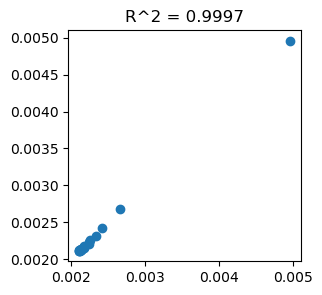

In [14]:
plt.figure(figsize=(3,3))
plt.scatter(values, values_pred)
r, p = pearsonr(
    values, values_pred
)
plt.title(f"R^2 = {round(r**2, 4)}")

## Calculate $d\sigma/dz$ for all timestamps, tower measurements at all heights >= 2

In [15]:
def get_dsigma_dz_values_for_height(H):
    dsigma_dz = mixing_ratio_profile_df.reset_index().swifter.groupby('time').apply(
        lambda df: calculate_mixingratio_gradient(df, H)[
            :3 # drop the extra outputs
        ]
    )
    dsigma_dz = pd.DataFrame(dsigma_dz.tolist()).rename(columns={
        0: 'dsigma_dz',
        1: 'fit_param_a',
        2: 'fit_param_b',
        # 3: 'heights',
        # 4: 'values', 
        # 5: 'values_pred'
    }).assign(time = dsigma_dz.index).set_index('time')

    return dsigma_dz.drop_duplicates()

def add_variables_to_dsigma_dz_values(H, dsigma_dz_values, tidy_df_specific_pf):
    return dsigma_dz_values.join(
        tidy_df_specific_pf.query(f"variable == 'w_{H}m_c'").set_index('time')['value'].rename('w')
    ).join(
        tidy_df_specific_pf.query(f"variable == 'airdensity_{H}m_c'").set_index('time')['value'].rename('rho_d')
    ).join(
        tidy_df_specific_pf.query(f"variable == 'w_h2o__{H}m_c_gapfill'").set_index('time')['value'].rename('w_h2o__')
    )

def calculate_transport_terms_with_dsigma_dz(H, dsigma_dz_values):
    dsigma_dz_values['vertical_advection'] = dsigma_dz_values['w']*dsigma_dz_values['rho_d']*dsigma_dz_values['dsigma_dz']*1000
    dsigma_dz_values['w_h2o__corrected'] = (dsigma_dz_values['w_h2o__'] + dsigma_dz_values['vertical_advection']*H)
    return dsigma_dz_values

def get_advection_and_cumsum_df(H, tidy_df_specific_pf):
    df = get_dsigma_dz_values_for_height(H)
    df = add_variables_to_dsigma_dz_values(H, df, tidy_df_specific_pf) 
    df = calculate_transport_terms_with_dsigma_dz(H, df)

    cumsum_df = df.loc['20221130': '20230509']
    cumsum_df['w_h2o___cumsum'] = cumsum_df['w_h2o__'].cumsum()
    cumsum_df['w_h2o__corrected_cumsum'] = cumsum_df['w_h2o__corrected'].cumsum()
    return df, cumsum_df


In [16]:
def get_dsigma_dz_values_for_height_with_full_outputs(H):
    dsigma_dz = mixing_ratio_profile_df.reset_index().swifter.groupby('time').apply(
        lambda df: calculate_mixingratio_gradient(df, H)
    )
    dsigma_dz = pd.DataFrame(dsigma_dz.tolist()).rename(columns={
        0: 'dsigma_dz',
        1: 'fit_param_a',
        2: 'fit_param_b',
        3: 'heights',
        4: 'values', 
        5: 'values_pred'
    }).assign(time = dsigma_dz.index).set_index('time')

    return dsigma_dz
# .drop_duplicates()

In [17]:
full_results_df = get_dsigma_dz_values_for_height_with_full_outputs(3)
full_results_df['R'] = full_results_df.apply(
    lambda row: pearsonr(
        row['values'], row['values_pred']
    )[0],
    axis=1
)
    
full_results_df

  0%|          | 0/22 [00:00<?, ?it/s]

2025-01-18 18:12:09,791	INFO worker.py:1781 -- Started a local Ray instance.


,dsigma_dz,fit_param_a,fit_param_b,heights,values,values_pred,R
time,,,,,,,
2022-11-07 00:30:00,0.000016,1.079063e-06,0.000033,0 0.005000 10700 0.970166 19801 ...,0 0.003788 10700 0.003922 19801 ...,"[0.0037815560761389035, 0.003983942531869855, ...",0.902054
2022-11-07 01:00:00,0.000016,5.147805e-08,0.000048,1 0.005000 10701 0.969213 19802 ...,1 0.003724 10701 0.003906 19802 ...,"[0.0037170996007383603, 0.003971498039035585, ...",0.923892
2022-11-07 01:30:00,0.000009,3.087405e-06,-0.000011,2 0.005000 10702 0.968931 19803 ...,2 0.003943 10702 0.003910 19803 ...,"[0.0039378885149878185, 0.0039634071455565915,...",0.685471
2022-11-07 02:00:00,0.000008,-3.789191e-06,0.000071,3 0.005000 10703 0.968649 19804 ...,3 0.003737 10703 0.003917 19804 ...,"[0.003728657153502014, 0.0039993884851627845, ...",0.870200
2022-11-07 02:30:00,0.000008,-2.040344e-06,0.000049,4 0.005000 10704 0.974681 19805 ...,4 0.003725 10704 0.003868 19805 ...,"[0.0037197512192992687, 0.003919842383426771, ...",0.849776
...,...,...,...,...,...,...,...
2023-06-18 21:30:00,-0.000065,-1.049297e-05,-0.000061,10695 0.005000 19796 0.994827 30496 ...,10695 0.006043 19796 0.005406 30496 ...,"[0.006040620813734335, 0.005424394836657558, 0...",0.998813
2023-06-18 22:00:00,-0.000048,-2.563188e-05,0.000185,10696 0.005000 19797 0.993332 30497 ...,10696 0.005296 19797 0.005586 30497 ...,"[0.0052981256013418295, 0.005559377607565806, ...",0.994628
2023-06-18 22:30:00,-0.000055,-3.093834e-05,0.000232,10697 0.005000 19798 0.994443 30498 ...,10697 0.005126 19798 0.005483 30498 ...,"[0.005123910402485432, 0.005484102527074768, 0...",0.995213


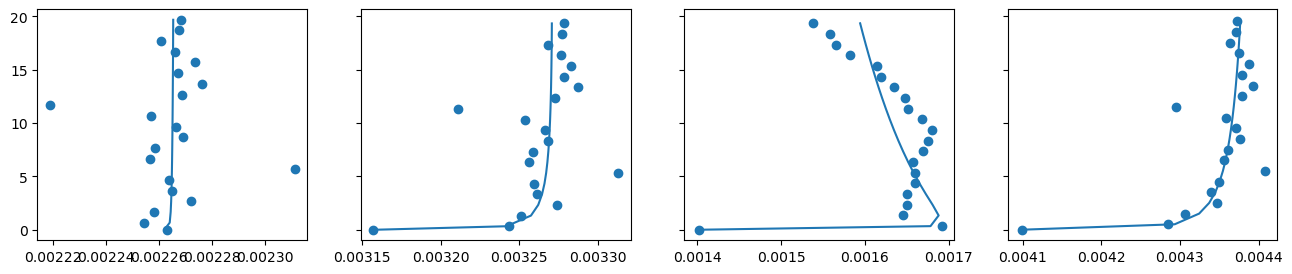

In [18]:
fig, axes = plt.subplots(1,4, figsize=(16,3), sharey=True, sharex=False)
axes[0].scatter(
    full_results_df.sort_values('R').iloc[0]['values'],
    full_results_df.sort_values('R').iloc[0]['heights'],
)
axes[0].plot(
    full_results_df.sort_values('R').iloc[0]['values_pred'],
    full_results_df.sort_values('R').iloc[0]['heights'],
)

axes[1].scatter(
    full_results_df.sort_values('R').iloc[500]['values'],
    full_results_df.sort_values('R').iloc[500]['heights'],
)
axes[1].plot(
    full_results_df.sort_values('R').iloc[500]['values_pred'],
    full_results_df.sort_values('R').iloc[500]['heights'],
)

axes[2].scatter(
    full_results_df.sort_values('R').iloc[1000]['values'],
    full_results_df.sort_values('R').iloc[1000]['heights'],
)
axes[2].plot(
    full_results_df.sort_values('R').iloc[1000]['values_pred'],
    full_results_df.sort_values('R').iloc[1000]['heights'],
)

axes[3].scatter(
    full_results_df.sort_values('R').iloc[1500]['values'],
    full_results_df.sort_values('R').iloc[1500]['heights'],
)
axes[3].plot(
    full_results_df.sort_values('R').iloc[1500]['values_pred'],
    full_results_df.sort_values('R').iloc[1500]['heights'],
)

In [19]:
### 3 sector
dsigma_dz_values_for_height = {
    2:      get_advection_and_cumsum_df(2,     tidy_df),
    3:      get_advection_and_cumsum_df(3,     tidy_df),
    5:      get_advection_and_cumsum_df(5,     tidy_df),
    10:     get_advection_and_cumsum_df(10,    tidy_df),
    15:     get_advection_and_cumsum_df(15,    tidy_df),
    20:     get_advection_and_cumsum_df(20,    tidy_df),
}
vertical_advection_estimates = pd.concat([
    df[0].assign(height = H) for (H, df) in dsigma_dz_values_for_height.items()
])
cumsub_vertical_advection_correction_estimates = pd.concat([
    df[1].assign(height = H) for (H, df) in dsigma_dz_values_for_height.items()
])

# calculate uncertainty
ds_uncertainty = 0.2 / 1000
vertical_advection_estimates['vertical_advection_uncertainty'] = vertical_advection_estimates['w'] * vertical_advection_estimates['rho_d'] * ds_uncertainty


  0%|          | 0/22 [00:00<?, ?it/s]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o___cumsum'] = cumsum_df['w_h2o__'].cumsum()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o__corrected_cumsum'] = cumsum_df['w_h2o__corrected'].cumsum()


  0%|          | 0/22 [00:00<?, ?it/s]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o___cumsum'] = cumsum_df['w_h2o__'].cumsum()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o__corrected_cumsum'] = cumsum_df['w_h2o__corrected'].cumsum()


  0%|          | 0/22 [00:00<?, ?it/s]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o___cumsum'] = cumsum_df['w_h2o__'].cumsum()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o__corrected_cumsum'] = cumsum_df['w_h2o__corrected'].cumsum()


  0%|          | 0/22 [00:00<?, ?it/s]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o___cumsum'] = cumsum_df['w_h2o__'].cumsum()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o__corrected_cumsum'] = cumsum_df['w_h2o__corrected'].cumsum()


  0%|          | 0/22 [00:00<?, ?it/s]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o___cumsum'] = cumsum_df['w_h2o__'].cumsum()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o__corrected_cumsum'] = cumsum_df['w_h2o__corrected'].cumsum()


  0%|          | 0/22 [00:00<?, ?it/s]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o___cumsum'] = cumsum_df['w_h2o__'].cumsum()
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/561014218.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cumsum_df['w_h2o__corrected_cumsum'] = cumsum_df['w_h2o__corrected'].cumsum()


In [20]:
vertical_advection_estimates_3m = vertical_advection_estimates.query("height == 3")

In [21]:
vertical_advection_estimates_3m = vertical_advection_estimates_3m.join(
    full_results_df[['R']]
)

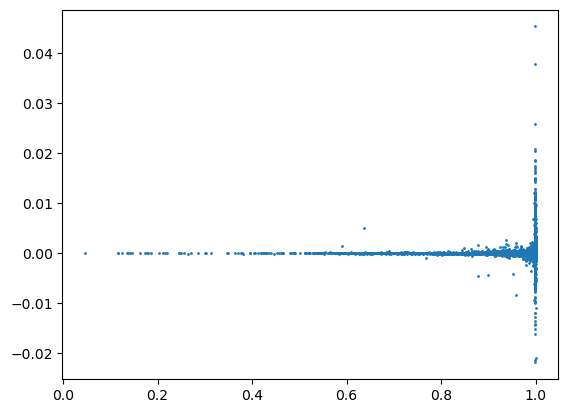

In [22]:
plt.scatter(
    vertical_advection_estimates_3m.R,
    vertical_advection_estimates_3m.vertical_advection,
    s=1
)
# plt.ylim(-.001,.001)

In [23]:
def get_casestudy_and_seasonal_charts(
        vert_adv_estimates_df,
        cumsub_estimates_df,
        casestudy_date = '20230505'
):
    flux_div = pd.DataFrame(
        (
            tidy_df.query(f"variable == 'w_h2o__10m_c_raw'").set_index('time').loc[casestudy_date]['value'] - \
            tidy_df.query(f"variable == 'w_h2o__3m_c_raw'").set_index('time').loc[casestudy_date]['value']
        ).rename('flux div') / 7
    ).reset_index()

    casestudy_chart = alt.Chart(
        flux_div
    ).transform_window(
        rolling_avg = 'mean(flux div)',
        frame = [-3, 3]
    ).mark_line(color='black').encode(
        alt.X('time:T'),
        alt.Y('rolling_avg:Q'),
    ) +\
    alt.Chart(
        vert_adv_estimates_df.loc[casestudy_date].reset_index()
    ).transform_window(
        rolling_avg = 'mean(vertical_advection)',
        frame = [-3, 3]
    ).mark_line().encode(
        alt.X('time:T'),
        alt.Y('rolling_avg:Q').scale(domain=[-0.003, 0.003]),
        alt.Color('height:O').scale(scheme='rainbow')
    ).properties(
        width=200,
        height=200
    )

    seasonal_sub_chart = alt.Chart(
        (cumsub_estimates_df.groupby([
        pd.Grouper(freq='24H'), 'height'
        ]).max() * 1.8).reset_index()
    ).transform_fold([
        'w_h2o___cumsum', 'w_h2o__corrected_cumsum'
    ]).mark_point(size=50).encode(
        alt.Y('height:N').sort('-y'),
        alt.X('max(value):Q').scale(domain=[20,42]),
        alt.Shape('key:N'),
        alt.Color('key:N')
    ).properties(
        width=200, height=200
    )

    seasonal_w_chart_upvalley = alt.Chart(
        cumsub_estimates_df[
            cumsub_estimates_df.index.isin(upvalley_wind_times)
        ].reset_index()
    ).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(w):Q').scale(domain=[-0.05,0.05]),
        alt.Color('height:O').scale(scheme='rainbow')
    ).properties(width=200, height=200)
    seasonal_w_chart_downvalley = alt.Chart(
        cumsub_estimates_df[
            cumsub_estimates_df.index.isin(downvalley_wind_times)
        ].reset_index()
    ).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('median(w):Q').scale(domain=[-0.05,0.05]),
        alt.Color('height:O').scale(scheme='rainbow')
    ).properties(width=200, height=200)

    return (
        seasonal_sub_chart & 
        # casestudy_chart & 
        seasonal_w_chart_upvalley & seasonal_w_chart_downvalley
    ).resolve_scale(shape='independent', color='independent')

In [24]:
get_casestudy_and_seasonal_charts(
    vertical_advection_estimates,
    cumsub_vertical_advection_correction_estimates,
    casestudy_date = '20230505'
).properties(title='Monthly planar fit')

alt.VConcatChart(...)

In [25]:
(
    get_casestudy_and_seasonal_charts(
        vertical_advection_estimates,
        cumsub_vertical_advection_correction_estimates,
        casestudy_date = '20230505'
    ).properties(title='Monthly planar fit')
).configure_legend(orient='top')

alt.VConcatChart(...)

# Air density flux term, finite difference

In [26]:
airdensityflux_df = tidy_df[tidy_df.variable.isin([
    'dryairdensity_3m_c',   'dryairdensity_20m_c',
    'T_3m_c',   'T_20m_c',
    'mixingratio_3m_c',   'mixingratio_20m_c',
    'w_tc__3m_c',   'w_tc__20m_c',
    'w_h2o__3m_c',   'w_h2o__20m_c',
])].pivot(index='time', columns='variable', values='value')

mean_mixing_ratio = tidy_df.query(
    "measurement == 'mixing ratio'"
).query(
    "height >= 3"
).query(
    "height <= 20"
).groupby('time').value.mean().rename('mixingratio_mean_3to17')

airdensityflux_df = airdensityflux_df.join(mean_mixing_ratio)

# ALL KELVIN
UNITS_FOR_T_MEAS = units('kelvin')
UNITS_FOR_SH_FLUX = units("kelvin*m/s")
airdensityflux_df['T_3m_c'] = (airdensityflux_df['T_3m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)
airdensityflux_df['T_20m_c'] = (airdensityflux_df['T_20m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)

# ALL CELSIUS
# UNITS_FOR_T_MEAS = units('degC')
# UNITS_FOR_SH_FLUX = units("degC*m/s")
# airdensityflux_df['T_3m_c'] = (airdensityflux_df['T_3m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)
# airdensityflux_df['T_20m_c'] = (airdensityflux_df['T_20m_c'].values * units("degC")).to(UNITS_FOR_T_MEAS)

mu = 1/0.622
air_density_flux = (
    (
        airdensityflux_df['mixingratio_mean_3to17'].values * units("g/g")
    ) * (
        (
            ((airdensityflux_df['dryairdensity_20m_c'].values * units("kg/m^3")) / (airdensityflux_df['T_20m_c'].values * UNITS_FOR_T_MEAS))
            * (1 + mu * (airdensityflux_df['mixingratio_20m_c'].values * units("g/g")))
            * (airdensityflux_df['w_tc__20m_c'].values * UNITS_FOR_SH_FLUX) + mu*(airdensityflux_df['w_h2o__20m_c'].values * units("g/m^2/s"))
        )
        -
        (
            ((airdensityflux_df['dryairdensity_3m_c'].values * units("kg/m^3")) / (airdensityflux_df['T_3m_c'].values * UNITS_FOR_T_MEAS))
            * (1 + mu * (airdensityflux_df['mixingratio_3m_c'].values * units("g/g")))
            * (airdensityflux_df['w_tc__3m_c'].values * UNITS_FOR_SH_FLUX) + mu*(airdensityflux_df['w_h2o__3m_c'].values * units("g/m^2/s"))
        )

    ) / (17 * units('m'))
).to(units('g/m^3/s'))

airdensityflux_df['air_density_flux'] = air_density_flux
air_density_flux

Magnitude,[1.2058476695711418e-05 -6.4359122672254795e-06 6.197734277407512e-06 ... -1.3867356712393477e-05 7.743201050101401e-05 -7.009958514622957e-05]
Units,gram/(meter3 second)


# Horizontal advection and storage change terms, finite difference

In [27]:
# combine mixing ratio measurements from the two sites into one dataframe 
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice(data_start_date, data_cutoff_date)
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements_2m = tidy_df.query("variable == 'mixingratio_2m_c'").set_index('time')['value'].rename('kps_2m')
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time')['value'].rename('kps_3m')
kps_mixingratio_measurements_4m = tidy_df.query("variable == 'mixingratio_4m_c'").set_index('time')['value'].rename('kps_4m')

kps_lateral_simple_df = kpsannex_mixingratio_measurements.join(
    kps_mixingratio_measurements_2m
).join(
    kps_mixingratio_measurements_3m
).join(
    kps_mixingratio_measurements_4m
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_df = kps_lateral_simple_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time')['value'].rename('dir_10m_c')
).join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time')['value'].rename('spd_3m_c')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)

kps_lateral_simple_df = kps_lateral_simple_df[
    ((kps_lateral_simple_df.dir_10m_c >= 112) & (kps_lateral_simple_df.dir_10m_c <= 152))
    |
    ((kps_lateral_simple_df.dir_10m_c >= 292) & (kps_lateral_simple_df.dir_10m_c <= 332))
]
# label each timestamp up or downvalley
kps_lateral_simple_df['direction'] = kps_lateral_simple_df['dir_10m_c'].apply(lambda x: 'down' if 292 <= x <= 332 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_df['ds_2m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_2m'] if row['direction'] == 'down' else row['kps_2m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['ds_3m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_3m'] if row['direction'] == 'down' else row['kps_3m'] - row['annex'],
    axis=1
)

kps_lateral_simple_df['ds_3m_uncertainty'] = 0.2/1000

kps_lateral_simple_df['ds_4m'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps_4m'] if row['direction'] == 'down' else row['kps_4m'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['dx'] = 400
kps_lateral_simple_df['ds/dx 2m'] = kps_lateral_simple_df['ds_2m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m'] = kps_lateral_simple_df['ds_3m'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 3m uncertainty'] = kps_lateral_simple_df['ds_3m_uncertainty'] / kps_lateral_simple_df['dx']
kps_lateral_simple_df['ds/dx 4m'] = kps_lateral_simple_df['ds_4m'] / kps_lateral_simple_df['dx']

kps_lateral_simple_df['lateral_advection_2m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 2m']
kps_lateral_simple_df['lateral_advection_3m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m']
kps_lateral_simple_df['lateral_advection_3m_uncertainty'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 3m uncertainty']
kps_lateral_simple_df['lateral_advection_4m'] = kps_lateral_simple_df['spd_3m_c'] * kps_lateral_simple_df['rho'] * kps_lateral_simple_df['ds/dx 4m']


kps_lateral_simple_df['ds/dt'] = kps_lateral_simple_df['rho'] * (kps_lateral_simple_df[['kps_2m', 'kps_3m', 'kps_4m']].mean(axis=1)).diff() * units('g/g') / (30*60*units('seconds'))
# kps_lateral_simple_df

In [28]:
src = kps_lateral_simple_df[['lateral_advection_3m', 'lateral_advection_3m_uncertainty']]
src['ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
src['lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']

alt.Chart(src.reset_index()).mark_area(opacity=0.5).encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lb):Q'),
    alt.Y2('mean(ub):Q')
) + alt.Chart(src.reset_index()).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('mean(lateral_advection_3m):Q'),
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/3574805051.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_9753/3574805051.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src['lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']


alt.LayerChart(...)

# Aggregate results

In [29]:
meas_vars_df = pd.DataFrame(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
).join(
    tidy_df.query("variable == 'w_h2o__2m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__2m_c')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c')
).join(
    tidy_df.query("variable == 'w_h2o__15m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__15m_c')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c_gapfill'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__2m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__2m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__5m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__5m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__10m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__10m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__15m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__15m_c_raw')
).join(
    tidy_df.query("variable == 'w_h2o__20m_c_raw'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__20m_c_raw')
)

In [30]:
advection_1d_fluxdensity_nonnorm_df = meas_vars_df[[
    'w_h2o__2m_c', 'w_h2o__3m_c', 'w_h2o__5m_c', 'w_h2o__10m_c', 'w_h2o__15m_c', 'w_h2o__20m_c',
    'w_h2o__2m_c_raw', 'w_h2o__3m_c_raw', 'w_h2o__5m_c_raw', 'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw', 'w_h2o__20m_c_raw'
]].join(
    kps_lateral_simple_df[['lateral_advection_2m', 'lateral_advection_3m', 'lateral_advection_4m', 'lateral_advection_3m_uncertainty']]
).join(
    kps_lateral_simple_df[['ds/dt']]
).join(
    airdensityflux_df['air_density_flux']
).join(
    vertical_advection_estimates.query("height == 2")['vertical_advection'].rename('vertical_advection_numerical_2')
).join(
    vertical_advection_estimates.query("height == 2")['vertical_advection_uncertainty'].rename('vertical_advection_uncertainty_numerical_2')
).join(
    vertical_advection_estimates.query("height == 3")['vertical_advection'].rename('vertical_advection_numerical_3')
).join(
    vertical_advection_estimates.query("height == 3")['vertical_advection_uncertainty'].rename('vertical_advection_uncertainty_numerical_3')
).join(
    vertical_advection_estimates.query("height == 5")['vertical_advection'].rename('vertical_advection_numerical_5')
).join(
    vertical_advection_estimates.query("height == 5")['vertical_advection_uncertainty'].rename('vertical_advection_uncertainty_numerical_5')
).join(
    vertical_advection_estimates.query("height == 10")['vertical_advection'].rename('vertical_advection_numerical_10')
).join(
    vertical_advection_estimates.query("height == 10")['vertical_advection_uncertainty'].rename('vertical_advection_uncertainty_numerical_10')
).join(
    vertical_advection_estimates.query("height == 15")['vertical_advection'].rename('vertical_advection_numerical_15')
).join(
    vertical_advection_estimates.query("height == 15")['vertical_advection_uncertainty'].rename('vertical_advection_uncertainty_numerical_15')
).join(
    vertical_advection_estimates.query("height == 20")['vertical_advection'].rename('vertical_advection_numerical_20')
).join(
    vertical_advection_estimates.query("height == 20")['vertical_advection_uncertainty'].rename('vertical_advection_uncertainty_numerical_20')
)

# Estimate uncertainty in the mixing ratio 

For estimating uncertainty in the vertical advection terms:

$$W \rho \frac{d s}{d z}$$

where our uncertainty in:
* W is $\pm$ 0.001 m/s (u and v are +/- 1mm, w is +/- 0.5mm, but w planar fitted involves u, v, and w, so we juse use 1mm/s)
* $s$ is 0.1 g/kg ()
* $\rho$ is a function of P and T, where T 
  * For the Paroscientific 6000 nanobarometer, they estimate +/- 0.01% error. We commonly estimate around 700mb, so let's say +/- 0.1
  * For the Sensirion SHT85 T measurement, manufacturer reported error is $\pm$ 0.1	°C
  * For the Sensirion SHT85 RH measurement, manufacturer reported error is $\pm$ 1.5 %
* $\frac{d s}{d z}$ as 0.2 g/kg (I have no idea if this is correct or makes any sense) 
then our estimate of uncertainty for the whole term is 

For estimating error in mixing ratio:

We calculate mixing ratio from instrument measurements of pressure, temperature, relative_humidity:

```
metpy.calc.mixing_ratio_from_relative_humidity(
  pressure,
  temperature,
  relative_humidity
)
```

In [127]:
# CHOOSE OUR T, P, RH values by calculating the mean of each variable
# P = tidy_df.query("variable == 'P_10m_c'").set_index('time').value.mean()
# T = tidy_df.query("variable == 'T_10m_c'").set_index('time').value.mean()
# RH = tidy_df.query("variable == 'RH_10m_c'").set_index('time').value.mean()

# CHOOSE OUR T, P, RH values by selecting a median or quantile T value, and use that same timestamp to select P and RH values
t_values_sorted = tidy_df.query("variable == 'T_10m_c'").set_index('time').value.sort_values().dropna()
i_median = int(len(t_values_sorted) / 2)
i_quartile_hi = int(len(t_values_sorted) / 4)
i_quartile_hi = int(len(t_values_sorted) / 2 + len(t_values_sorted) / 4)
i_quantile_10percent_low = int(len(t_values_sorted)*0.1)
i_quantile_10percent_hi = int(len(t_values_sorted)*0.9)

T = t_values_sorted[i_quantile_10percent_hi]
index = t_values_sorted.index[i_quantile_10percent_hi]
P = tidy_df.query("variable == 'P_10m_c'").set_index('time').value.loc[index]
RH = tidy_df.query("variable == 'RH_10m_c'").set_index('time').value.loc[index]
index, T, P, RH

(Timestamp('2023-04-18 15:30:00'),
 7.3692626953125,
 710.21484375,
 22.366437911987305)

In [128]:
from uncertainties import ufloat
import numpy as np

P_mean = P  # Assuming P is already defined
P_error = P * 0.0001
P_std = P_error / 2  # Standard deviation of 0.01%

T_mean = T  # Assuming P is already defined
T_error = 0.1
T_std = T_error / 2  # Standard deviation of 0.01%

RH_mean = RH  # Assuming P is already defined
RH_error = 1.5
RH_std = RH_error / 2  # Standard deviation of 0.01%


Samples = pd.DataFrame({
    'P': np.random.normal(P_mean, P_std, 5000),
    'T': np.random.normal(T_mean, T_std, 5000),
    'RH': np.random.normal(RH_mean, RH_std, 5000),
})

In [129]:
P_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('P:Q').bin(step = 0.01).title('Mean pressure value + random errors (millibars)').scale(nice=False),
        alt.Y('count():Q')
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(P):Q')
).properties(width=300, height = 100)
T_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('T:Q').bin(step = 0.01).title('Mean temperature value + random errors (˚C)').scale(nice=False),
        alt.Y('count():Q'),
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(T):Q')
).properties(width=300, height = 100)
RH_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('RH:Q').bin(step = 0.2).title('Mean RH value + random errors (%)').scale(nice=False),
        alt.Y('count():Q')
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(RH):Q')
).properties(width=300, height = 100)

In [130]:
from metpy.calc import mixing_ratio_from_relative_humidity

In [131]:
Samples['s'] = Samples.apply(
    lambda ro: mixing_ratio_from_relative_humidity(
    ro['P']*units("millibars"), ro['T']*units("degC"), ro['RH']*units("percent")
    ).to(units("g/kg")).magnitude, 
    axis=1
)
s_2_sigma = round(2*Samples['s'].std(), 3)
s_2_sigma

0.136

In [132]:
s_dist = (
    alt.Chart(Samples).mark_bar().encode(
        alt.X('s:Q').bin(step = 0.01).scale(nice=False).title(['Water vapor ratio (g/Kg), values calculated through', 'Monte Carlo propagation of T, RH, and P errors']),
        alt.Y('count():Q')
    ) + alt.Chart(Samples).mark_rule(
        color='red', strokeWidth=2
    ).encode(x='mean(s):Q')
).properties(
    width=300, height = 100,
    title=f"2σ = {s_2_sigma}"
)

In [133]:
P_dist & T_dist & RH_dist & s_dist

alt.VConcatChart(...)

In [134]:
src = mixing_ratio_profile_df.query("height == 2")[['value']].rename(columns={'value': 's_2m'}).join(
    mixing_ratio_profile_df.query("height == 20")['value'].rename('s_20m')
)
src_vert = src['s_20m'] - src['s_2m']
src_horiz = kps_lateral_simple_df['ds_3m']

rule = alt.Chart().mark_rule().transform_calculate(x=f'{s_2_sigma}').encode(x='x:Q')
rule2 = alt.Chart().mark_rule().transform_calculate(x=f'-{s_2_sigma}').encode(x='x:Q')
rule + rule2 + alt.Chart(
    (pd.DataFrame(src_vert.rename('vertical')).join(src_horiz.rename('horizontal'))*1000).query("vertical > -1").query("horizontal > -1")
).mark_bar(color='blue', opacity=0.5).encode(
    alt.X('vertical:Q').bin(step=0.05).title("∆ (Water vapor mixing ratio) (g/Kg)"),
    alt.Y('count():Q').stack(None),
) + alt.Chart(
    (pd.DataFrame(src_vert.rename('vertical')).join(src_horiz.rename('horizontal'))*1000).query("vertical > -1").query("horizontal > -1")
).mark_bar(color='red', opacity=0.5).encode(
    alt.X('horizontal:Q').bin(step=0.05),
    alt.Y('count():Q').stack(None),
).properties(height = 200)

alt.LayerChart(...)

In [ ]:
import metpy.calc
mean_p = tidy_df.query("variable == 'P_10m_c'").value.mean() * units("millibars")
mean_t = tidy_df.query("variable == 'T_10m_c'").value.mean() * units("degC")
print(round(metpy.calc.density(mean_p, mean_t, 0).magnitude.item(), 4))

print()
print("varying P +/- 20millibars")
print(round(metpy.calc.density(mean_p + 20*units("millibars"), mean_t, 0).magnitude.item(), 4))
print(round(metpy.calc.density(mean_p - 20*units("millibars"), mean_t, 0).magnitude.item(), 4))

print()
print("varying T +/- 2˚C")
print(round(metpy.calc.density(mean_p, mean_t + 2*units("delta_degC"), 0).magnitude.item(), 4))
print(round(metpy.calc.density(mean_p, mean_t - 2*units("delta_degC"), 0).magnitude.item(), 4))

In [ ]:
advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_2_lb'] = advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_2'] - 0.0014
advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_2_ub'] = advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_2'] + 0.0014
base = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[advection_1d_fluxdensity_nonnorm_df.index.isin(downvalley_nobs_times)].reset_index()
).encode(
    alt.X('hours(time):T'),
)
adv_2m_chart = (
    base.mark_line().encode(alt.Y('mean(vertical_advection_numerical_2)'))
    + 
    base.mark_area(opacity=0.25).encode(
        alt.Y('mean(vertical_advection_numerical_2_lb)'),
        alt.Y2('mean(vertical_advection_numerical_2_ub)').title('Vertical advection')
    )
)

advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_3_lb'] = advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_3'] - 0.0014
advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_3_ub'] = advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_3'] + 0.0014
base = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[advection_1d_fluxdensity_nonnorm_df.index.isin(downvalley_nobs_times)].reset_index()
).encode(
    alt.X('hours(time):T'),
)
adv_3m_chart = (
    base.mark_line().encode(alt.Y('mean(vertical_advection_numerical_3)'))
    + 
    base.mark_area(opacity=0.25).encode(
        alt.Y('mean(vertical_advection_numerical_3_lb)'),
        alt.Y2('mean(vertical_advection_numerical_3_ub)').title('Vertical advection')
    )
)

advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_5_lb'] = advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_5'] - 0.0014
advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_5_ub'] = advection_1d_fluxdensity_nonnorm_df['vertical_advection_numerical_5'] + 0.0014
base = alt.Chart(
    advection_1d_fluxdensity_nonnorm_df[advection_1d_fluxdensity_nonnorm_df.index.isin(downvalley_nobs_times)].reset_index()
).encode(
    alt.X('hours(time):T'),
)
adv_5m_chart = (
    base.mark_line().encode(alt.Y('mean(vertical_advection_numerical_5)'))
    + 
    base.mark_area(opacity=0.25).encode(
        alt.Y('mean(vertical_advection_numerical_5_lb)'),
        alt.Y2('mean(vertical_advection_numerical_5_ub)').title('Vertical advection')
    )
)

(adv_2m_chart | adv_3m_chart | adv_5m_chart).resolve_scale(y='shared')

# Turbulent flux divergence terms, finite difference

Calculate $$ \frac{\Delta \overline{w'q'}}{\Delta z} \quad \text{and} \quad  \frac{\Delta \overline{w'q'}}{\Delta z}$$

In [ ]:
advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to20'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__20m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c_raw']
) / 17

advection_1d_fluxdensity_nonnorm_df['vertical_turb_flux_divergence_3to10'] = (
    advection_1d_fluxdensity_nonnorm_df['w_h2o__10m_c_raw'] - advection_1d_fluxdensity_nonnorm_df['w_h2o__3m_c_raw']
) / 7

# Plot water vapor transport results

## Seasonal Composite Analysis - Non Blowing Snow Conditions

Define  plotting functions

In [ ]:
PLOT_WIDTH = 150
PLOT_HEIGHT = 150

# Function to plot diurnal cycles in conservation terms, for the vertical advection estimates using a numerical solution
########################################################
def get_vert_advection_with_height(src, title):
    vars = [ 
        # 'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]
    vert_advection_chart = alt.Chart(src).mark_line().transform_fold(
        vars
    ).encode(
        alt.X('hours(time):T').axis(labelAlign='center'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(domain = [-0.00025, 0.00025], clamp=True),
        alt.Color('key:N').sort(vars).scale(scheme='turbo')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    flux_div_chart = alt.Chart(src).mark_line(
        color='black'
    ).transform_fold([
        'ds/dt', 'vertical_turb_flux_divergence_3to20'
    ]).encode(
        alt.X('hours(time):T').axis(labelAlign='center'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(domain = [-0.00025, 0.00025], clamp=True),
        alt.StrokeDash('key:N')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    return (vert_advection_chart + flux_div_chart)
    

# Function to plot diurnal cycles in conservation terms, for the vertical advection estimates using a finite difference solution
def get_chart_with_errorbands(src, title):
    vars = [
            'vertical_turb_flux_divergence_3to20', 
            # 'vertical_advection_simple_2to10',  
            # 'vertical_advection_simple_2to20',  
            'ds/dt',
            #  'air_density_flux'
        ]
    colors = [
        # black + rainbow scheme
        'black', 'grey'
        # '#f80c12','#ff9933','#ccbb33','#69d025','#3311bb','#442299'
        # simple color scheme
        # '#ff7f0e', '#1f77b4',  '#2ca02c', , 'grey' 
            ]
    all_data_chart = alt.Chart(src).mark_line().transform_fold(
        vars
    ).encode(
        alt.X('hours(time):T').axis(labelAlign='center'),
        alt.Y('median(value):Q').title('Flux density (g/m^3/s)').scale(domain = [-0.00025, 0.00025], clamp=True),
        alt.Color('key:N').scale(
            domain = vars,range = colors
        )
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)
    all_data_chart_vert_adv_uncertainty = alt.Chart(src).mark_area(
        color = colors[1],
        opacity=0.35
    ).encode(
        alt.X('hours(time):T'),
        alt.Y('median(vertical_advection_lb):Q').title(''),
        alt.Y2('median(vertical_advection_ub):Q').title(''),
    )
    return all_data_chart_vert_adv_uncertainty + all_data_chart 

# Function to plot diurnal cycles in profiles
########################################################
def plot_profiles(src):
    return alt.Chart(src).transform_filter(
        alt.datum.height > 1
    ).transform_filter(
        alt.datum.height != 12
    ).transform_filter(
        alt.datum.height != 6
    ).mark_line(
        point={'size':20}, strokeWidth=1
    ).encode(
        alt.X('median(value):Q').scale(zero=False).title('Mixing ratio (g/Kg)'),
        alt.Y('height:Q').title('Height (m)'),
                
        alt.Color('conditions:N', sort=
                  ['0-3','3-6','6-9','9-12','12-15','15-18','18-21','21-0' ]
                ).title(
            'time (hours)'
        ),
        alt.Order('height:Q')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT)
def plot_profiles_nocolor(src):
    return alt.Chart(src).transform_filter(
        alt.datum.height > 1
    ).transform_filter(
        alt.datum.height != 12
    ).transform_filter(
        alt.datum.height != 6
    ).mark_line(
        point={'size':20, 'color': 'black'}, strokeWidth=1, color='black'
    ).encode(
        alt.X('median(value):Q').scale(zero=False).title('Mixing ratio (g/Kg)'),
        alt.Y('height:Q').title('Height (m)'),
        alt.Order('height:Q'),
        alt.Detail('conditions:N')
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT)

# Function to plot diurnal cycles in w
########################################################
def w_diurnal_chart(src, title):
    line = alt.Chart().transform_calculate(y = '0').mark_rule().encode(y='y:Q')
    return alt.layer(
        line, 
        alt.Chart().mark_line().encode(
            alt.X('hours(time):T').axis(labelAlign='center', values=[0,6,12,18,]),
            alt.Y('median(value):Q').title('Vertical velocity (m/s)').scale(domain = [-0.05, 0.05], clamp=True),
            alt.Color('height:O').scale(scheme='turbo')
        ), 
        data = src
    ).properties(width=PLOT_WIDTH, height=PLOT_HEIGHT, title=title)

Isolate data

In [ ]:
# Identify timestamps for the two categories
upvalley_nobs_times = set(pd.to_datetime(upvalley_wind_times)).intersection(set(nobs_times))
downvalley_nobs_times = set(pd.to_datetime(downvalley_wind_times)).intersection(set(nobs_times))

# Data for diurnal cycles in CONSERVATION TERMS, FINITE DIFFERENCE METHOD
########################################################
src_cons_terms_numerical = advection_1d_fluxdensity_nonnorm_df.copy()
src_cons_terms_numerical_upvalley_nobs = src_cons_terms_numerical[src_cons_terms_numerical.index.isin(upvalley_nobs_times)].reset_index()
src_cons_terms_numerical_dovalley_nobs = src_cons_terms_numerical[src_cons_terms_numerical.index.isin(downvalley_nobs_times)].reset_index()

# Data for diurnal cycles in MIXING RATIO PROFILES
########################################################
src_mixingratio = tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'")
src_mixingratio = src_mixingratio[src_mixingratio.time.isin(nobs_times)]
src_mixingratio['conditions'] = src_mixingratio.time.dt.hour
# src_mixingratio = src_mixingratio[src_mixingratio.conditions % 4 == 0]
src_mixingratio['conditions'] = pd.cut(
    src_mixingratio.time.dt.hour,
    [-1,3,6,9,12,15,18,21,24],
    labels=['0-3', '3-6', '6-9', '9-12', '12-15', '15-18', '18-21', '21-0'],
    right=False
)

src_mixingratio = src_mixingratio[
    src_mixingratio['conditions'].isin([ '0-3', '6-9', '12-15', '18-21'])
]
src_mixingratio['value'] = src_mixingratio['value']*1000
src_mixingratio_upvalley_nobs = src_mixingratio[src_mixingratio.time.isin(upvalley_nobs_times)].query("height > 1")
src_mixingratio_dovalley_nobs = src_mixingratio[src_mixingratio.time.isin(downvalley_nobs_times)].query("height > 1")

# Data for diurnal cycles in MEAN W
########################################################
src_w = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")
src_w_upvalley_nobs = src_w[src_w.time.isin(upvalley_nobs_times)]
src_w_dovalley_nobs = src_w[src_w.time.isin(downvalley_nobs_times)]
src_w_upvalley_nobs = src_w_upvalley_nobs.query("height > 1")

src_w_dovalley_nobs = src_w_dovalley_nobs.query("height > 1")

In [ ]:
s_profile_charts = (
    plot_profiles_nocolor(src_mixingratio_upvalley_nobs).properties(title='') &\
    plot_profiles_nocolor(src_mixingratio_dovalley_nobs).properties(title='')
)
w_charts = (
    w_diurnal_chart(src_w_upvalley_nobs.query("height > 2"), title='') &\
    w_diurnal_chart(src_w_dovalley_nobs.query("height > 2"), title='')
).resolve_scale(y='shared')
conservation_charts_numerical = (
    get_vert_advection_with_height(src_cons_terms_numerical_upvalley_nobs, title='') &\
    get_vert_advection_with_height(src_cons_terms_numerical_dovalley_nobs, title='')
)

(
    (
        s_profile_charts | conservation_charts_numerical | w_charts
    ).resolve_scale(color='independent', strokeDash='independent')
).configure_legend(orient='top', columns=1)

In [ ]:
upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].dropna().query("value < 152").query("value > 92").drop_duplicates().time
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].dropna().query("value < 342").query("value > 292").drop_duplicates().time
all_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].drop_duplicates().time
print(round(len(upvalley_wind_times)/len(all_wind_times),3))
print(round(len(downvalley_wind_times)/len(all_wind_times),3))

In [ ]:
from windrose import WindroseAxes
src = tidy_df[tidy_df.time.isin(downvalley_wind_times)][
    tidy_df.variable.isin(['spd_20m_c', 'dir_20m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()
ax = WindroseAxes.from_ax(figsize=(2,2))
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=.9, edgecolor='white', bins=1, nsector=17)
ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
plt.title("20m wind rose")

In [ ]:
from windrose import WindroseAxes
src = tidy_df[tidy_df.time.isin(upvalley_wind_times)][
    tidy_df.variable.isin(['spd_20m_c', 'dir_20m_c'])
].pivot_table(values = 'value', index='time', columns=['measurement']).reset_index()
ax = WindroseAxes.from_ax(figsize=(2,2))
ax.bar(src['wind direction'], src['wind speed'], normed=True, opening=.9, edgecolor='white', bins=1, nsector=17)
ax.set_yticks([])
# ax.set_yticklabels(['10%','25%'])
plt.title("20m wind rose")

## Analyze seasonal advection corrections

$$ \overline{w'\rho_v'}_{0} = \overline{w'\rho_v'}_{H} + \int_0^H \overline{w} \rho \frac{d \sigma}{d z} dz$$

$$\int_0^H \overline{w} \rho \frac{d \sigma}{d z} = \int_0^2 \overline{w}\Big|_{z=2} \rho \frac{d \sigma}{d z}\Big|_{z=2} dz
+ \int_2^{4} \overline{w}\Big|_{z=3} \rho \frac{d \sigma}{d z}\Big|_{z=3} dz
+ \int_4^{8} \overline{w}\Big|_{z=5} \rho \frac{d \sigma}{d z}\Big|_{z=5} dz
+ \int_8^{13} \overline{w}\Big|_{z=10} \rho \frac{d \sigma}{d z}\Big|_{z=10} dz
+ \int_{13}^{18} \overline{w}\Big|_{z=15} \rho \frac{d \sigma}{d z}\Big|_{z=15} dz
+ \int_{18}^{20} \overline{w}\Big|_{z=20} \rho \frac{d \sigma}{d z}\Big|_{z=20} dz
$$

$$\int_0^H \overline{w} \rho \frac{d \sigma}{d z} = (2) \overline{w}_{2} \rho \frac{d \sigma}{d z}\Big|_{z=2} dz
+ 2 * \overline{w}_{3} \rho \frac{d \sigma}{d z}_{3}
+ 4 * \overline{w}_{5} \rho \frac{d \sigma}{d z}_{5}
+ 5 * \overline{w}_{10} \rho \frac{d \sigma}{d z}_{10}
+ 5 * \overline{w}_{15} \rho \frac{d \sigma}{d z}_{15}
+ 2 * \overline{w}_{20} \rho \frac{d \sigma}{d z}_{20}
$$

In [ ]:
# 2 meter corrections 
w_h2o__2m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__2m_c).cumsum()
w_h2o__2m_c_corrected_cumsum = ((1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__2m_c
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_2)
)
).cumsum()

# 3 meter corrections
w_h2o__3m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__3m_c).cumsum()
w_h2o__3m_c_corrected_cumsum = ((1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__3m_c
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_2)
        + (1*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_3)
)
).cumsum()

# 5 meter corrections
w_h2o__5m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__5m_c).cumsum()
w_h2o__5m_c_corrected_cumsum = ((1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__5m_c
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_2)
        + (1*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_3)
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_5)
)
).cumsum()

# 10 meter corrections
w_h2o__10m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__10m_c).cumsum()
w_h2o__10m_c_corrected_cumsum = ((1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__10m_c
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_2)
        + (1*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_3)
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_5)
        + (5*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_10)
)
).cumsum()

# 15 meter corrections
w_h2o__15m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__15m_c).cumsum()
w_h2o__15m_c_corrected_cumsum = ((1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__15m_c
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_2)
        + (1*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_3)
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_5)
        + (5*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_10)
        + (5*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_15)
)
).cumsum()

# 20 meter corrections
w_h2o__20m_c_cumsum = ((1800/1000)*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__20m_c).cumsum()
w_h2o__20m_c_corrected_cumsum = ((1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].w_h2o__20m_c
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_2)
        + (1*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_3)
        + (2*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_5)
        + (5*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_10)
        + (5*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_15)
        + (5*advection_1d_fluxdensity_nonnorm_df.loc['20221107': '20230618'].vertical_advection_numerical_20)
)
).cumsum()

In [ ]:

w_h2o__2m_c_cumsum.plot(           color = 'black',     linestyle = '-', label=r"$\overline{w'\rho_v'}$ (2m)")
w_h2o__2m_c_corrected_cumsum.plot( color = 'black',     linestyle = 'dotted',   label='w/ correction')
w_h2o__3m_c_cumsum.plot(           color = 'tab:blue',     linestyle = '-', label=r"$\overline{w'\rho_v'}$ (3m)")
w_h2o__3m_c_corrected_cumsum.plot( color = 'tab:blue',     linestyle = 'dotted',   label='w/ correction')
w_h2o__5m_c_cumsum.plot(           color = 'tab:orange',     linestyle = '-', label=r"$\overline{w'\rho_v'}$ (5m)")
w_h2o__5m_c_corrected_cumsum.plot( color = 'tab:orange',     linestyle = 'dotted',   label='w/ correction')
w_h2o__10m_c_cumsum.plot(           color = 'tab:red',     linestyle = '-', label=r"$\overline{w'\rho_v'}$ (10m)")
w_h2o__10m_c_corrected_cumsum.plot( color = 'tab:red',     linestyle = 'dotted',   label='w/ correction')
w_h2o__15m_c_cumsum.plot(           color = 'tab:green',     linestyle = '-', label=r"$\overline{w'\rho_v'}$ (15m)")
w_h2o__15m_c_corrected_cumsum.plot( color = 'tab:green',     linestyle = 'dotted',   label='w/ correction')
w_h2o__20m_c_cumsum.plot(           color = 'tab:purple',     linestyle = '-', label=r"$\overline{w'\rho_v'}$ (20m)")
w_h2o__20m_c_corrected_cumsum.plot( color = 'tab:purple',     linestyle = 'dotted',   label='w/ correction')

plt.legend(loc='lower left')
plt.ylabel('Cumulative sublimation (mm)')
plt.xlim('20230501', '20230620')

print('w_h2o__2m_c,     \t\t',          round(w_h2o__2m_c_cumsum.max(), 1))
print('w_h2o__2m_c_corrected,   \t',          round(w_h2o__2m_c_corrected_cumsum.max(), 1), round(100*w_h2o__2m_c_corrected_cumsum.max()/ w_h2o__2m_c_cumsum.max(), 1))
print('w_h2o__3m_c,     \t\t',          round(w_h2o__3m_c_cumsum.max(), 1))
print('w_h2o__3m_c_corrected,   \t',          round(w_h2o__3m_c_corrected_cumsum.max(), 1), round(100*w_h2o__3m_c_corrected_cumsum.max()/ w_h2o__3m_c_cumsum.max(), 1))
print('w_h2o__10m_c,    \t\t',          round(w_h2o__10m_c_cumsum.max(), 1))
print('w_h2o__10m_c_corrected,  \t',          round(w_h2o__10m_c_corrected_cumsum.max(), 1), round(100*w_h2o__10m_c_corrected_cumsum.max()/ w_h2o__10m_c_cumsum.max(), 1))
print('w_h2o__15m_c,    \t\t',          round(w_h2o__15m_c_cumsum.max(), 1))
print('w_h2o__15m_c_corrected,  \t',          round(w_h2o__15m_c_corrected_cumsum.max(), 1), round(100*w_h2o__15m_c_corrected_cumsum.max()/ w_h2o__15m_c_cumsum.max(), 1))
print('w_h2o__20m_c,    \t\t',          round(w_h2o__20m_c_cumsum.max(), 1))
print('w_h2o__20m_c_corrected,  \t',          round(w_h2o__20m_c_corrected_cumsum.max(), 1), round(100*w_h2o__20m_c_corrected_cumsum.max()/ w_h2o__20m_c_cumsum.max(), 1))

## Analyze case studies

### December case study

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221221 1200': '20221223 0000'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_advection_simple_3to10_uncertainty',
        'vertical_turb_flux_divergence_3to10',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt',
        'lateral_advection_3m_uncertainty',
        'vertical_advection_simple_3to20',
        'vertical_advection_simple_3to20_uncertainty',
        
        'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]].reset_index()


src['vertical_advection_lb'] = src['vertical_advection_simple_3to10'] - src['vertical_advection_simple_3to10_uncertainty']
src['vertical_advection_ub'] = src['vertical_advection_simple_3to10'] + src['vertical_advection_simple_3to10_uncertainty']

lines_chart = alt.Chart(src).transform_fold([
    'vertical_advection_simple_3to10',
    # 'vertical_advection_simple_3to20',
    'vertical_turb_flux_divergence_3to10',
    # 'vertical_turb_flux_divergence_3to20',
    # 'ds/dt',
]).mark_line().encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']).scale(
        domain = [-0.002, 0.005], clamp=True
    ),
    alt.Color('key:N', )
).properties(width=250, height = 166.66) 

vert_adv_uncert_chart = alt.Chart(src).mark_area(
    color = '#1f77b4',
    opacity=0.35
).encode(
    alt.X('time:T'),
    alt.Y('vertical_advection_lb:Q').title(''),
    alt.Y2('vertical_advection_ub:Q').title(''),
)    

bs_chart = alt.Chart(
    tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).mark_line(color='black').encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
    alt.StrokeDash('height:N', legend=None)
)

w_q_chart = alt.Chart(
    tidy_df[tidy_df.variable.isin(
        [
            'w_h2o__2m_c_raw', 'w_h2o__3m_c_raw', 
            'w_h2o__5m_c_raw', 
            'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw','w_h2o__20m_c_raw'])
    ].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-1,1],
    groupby = ['height']
).mark_line().encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('rolling_avg:Q').title(["w'q' (g/m^2/s)"]),
    alt.Color('height:O').scale(scheme='turbo')
)


(
    bs_chart.properties(width=250, height = 83.33)
    &
    w_q_chart.properties(width=250, height = 83.33)
    &
    (vert_adv_uncert_chart + lines_chart)
).resolve_scale(
    x='shared', color='independent', strokeDash='independent'
).display(renderer='svg')

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20221221 1200': '20221223 0000'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to10',
        'vertical_advection_simple_3to10_uncertainty',
        'vertical_turb_flux_divergence_3to10',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt',
        'lateral_advection_3m_uncertainty',
        'vertical_advection_simple_3to20',
        'vertical_advection_simple_3to20_uncertainty',
        
        'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]].reset_index()


src['vertical_advection_lb'] = src['vertical_advection_simple_3to10'] - src['vertical_advection_simple_3to10_uncertainty']
src['vertical_advection_ub'] = src['vertical_advection_simple_3to10'] + src['vertical_advection_simple_3to10_uncertainty']

lines_chart = alt.Chart(src).transform_fold([
    'vertical_advection_simple_3to10',
    # 'vertical_advection_simple_3to20',
    'vertical_turb_flux_divergence_3to10',
    # 'vertical_turb_flux_divergence_3to20',
    # 'ds/dt',
    'vertical_advection_numerical_2',
    'vertical_advection_numerical_3',
    'vertical_advection_numerical_5',
    'vertical_advection_numerical_10',
    'vertical_advection_numerical_15',
    'vertical_advection_numerical_20',
]).mark_line().encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Water vapor flux density', '(g/m^3/s)']).scale(
        domain = [-0.002, 0.005], clamp=True
    ),
    alt.Color('key:N', )
).properties(width=250, height = 166.66) 

vert_adv_uncert_chart = alt.Chart(src).mark_area(
    color = '#1f77b4',
    opacity=0.35
).encode(
    alt.X('time:T'),
    alt.Y('vertical_advection_lb:Q').title(''),
    alt.Y2('vertical_advection_ub:Q').title(''),
)    

bs_chart = alt.Chart(
    tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).mark_line(color='black').encode(
    alt.X('time:T'). axis(format='%m/%d').title(None),
    alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
    alt.StrokeDash('height:N', legend=None)
)

w_q_chart = alt.Chart(
    tidy_df[tidy_df.variable.isin(
        [
            'w_h2o__2m_c_raw', 'w_h2o__3m_c_raw', 
            'w_h2o__5m_c_raw', 
            'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw','w_h2o__20m_c_raw'])
    ].set_index('time').loc['20221221 1200': '20221223 0000'].reset_index()
).transform_window(
    rolling_avg = 'mean(value)',
    frame=[-1,1],
    groupby = ['height']
).mark_line().encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('rolling_avg:Q').title(["w'q' (g/m^2/s)"]),
    alt.Color('height:O').scale(scheme='turbo')
)


(
    bs_chart.properties(width=250, height = 83.33)
    &
    w_q_chart.properties(width=250, height = 83.33)
    &
    (vert_adv_uncert_chart + lines_chart)
).resolve_scale(
    x='shared', color='independent', strokeDash='independent'
).display(renderer='svg')

### April/May case studies

In [ ]:
def get_nice_advection_timeseries(date, date2=None, frame=[-2,2], width=300, height = 200, ydomain=[-0.001,0.001]):
    if date2 is None:
        date2 = date
    src = advection_1d_fluxdensity_nonnorm_df.loc[date: date2][[
            'w_h2o__3m_c',
            'w_h2o__20m_c',
            'vertical_advection_simple_3to10',
            'vertical_advection_simple_3to20',
            'vertical_advection_simple_3to20_uncertainty',
            'vertical_turb_flux_divergence_3to20',
            'lateral_advection_3m',
            'lateral_advection_3m_uncertainty',
            'ds/dt',
            
            'vertical_advection_numerical_2',
            'vertical_advection_numerical_3',
            'vertical_advection_numerical_5',
            'vertical_advection_numerical_10',
            'vertical_advection_numerical_15',
            'vertical_advection_numerical_20',
        ]].reset_index()

    src['vertical_advection_lb'] = src['vertical_advection_simple_3to20'] - src['vertical_advection_simple_3to20_uncertainty']
    src['vertical_advection_ub'] = src['vertical_advection_simple_3to20'] + src['vertical_advection_simple_3to20_uncertainty']
    src['lateral_advection_lb'] = src['lateral_advection_3m'] - src['lateral_advection_3m_uncertainty']
    src['lateral_advection_ub'] = src['lateral_advection_3m'] + src['lateral_advection_3m_uncertainty']

    flux_div_chart = alt.Chart(src).transform_fold([
        # 'vertical_advection_simple_3to10',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        # 'lateral_advection_3m',
        # 'ds/dt'
        'vertical_advection_numerical_2',
        'vertical_advection_numerical_3',
        'vertical_advection_numerical_5',
        'vertical_advection_numerical_10',
        'vertical_advection_numerical_15',
        'vertical_advection_numerical_20',
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=frame,
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']).scale(domain=ydomain, clamp=True),
        alt.Color('key:N')
    ).properties(width=width, height = height)

    vert_adv_errorbar = alt.Chart(src).transform_window(
        rollavg_vert_adv_lb = 'mean(vertical_advection_lb)',
        rollavg_vert_adv_ub = 'mean(vertical_advection_ub)',
        frame=frame,
        groupby = ['key']
    ).mark_area(
        opacity = 0.3,
        color = '#1f77b4'
    ).encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rollavg_vert_adv_lb:Q').title(''),
        alt.Y2('rollavg_vert_adv_ub:Q').title(''),
    )


    return  vert_adv_errorbar + flux_div_chart

In [ ]:
def get_chart(date):
    flux_div_chart = get_nice_advection_timeseries(date, ydomain=[-0.003,0.003]).properties(
        width=300, height = 125
    )

    w_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c','w_20m_c'])
        ].set_index('time').sort_index().loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Vertical wind speed (m/s)']),
        # alt.Y('value:Q').title(['Vertical wind speed (m/s)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    dir_chart = alt.Chart(
        tidy_df[
            tidy_df.variable == 'dir_20m_c'
        ].set_index('time').loc[date: date].reset_index()
    ).mark_line(color='black', strokeDash=[4,2]).encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('value:Q').title(['Wind direction']),
    ).properties(width=300, height = 125)

    mixingratio_chart = alt.Chart(
        tidy_df.query("measurement == 'mixing ratio'").set_index('time').loc[date: date].reset_index()
    ).transform_filter(
        'hours(datum.time)%3 == 0 & hours(datum.time)%6 != 0'
    ).transform_calculate(
        value_g_per_kg = '1000 * datum.value'
    ).mark_line().encode(
        alt.X('mean(value_g_per_kg):Q').sort('-y').title('s (g/kg)').scale(zero=True),
        alt.Y('height:Q'),
        alt.Facet('hours(time):O', spacing=5),
    ).properties(width=70, height = 70)

    # wspd_chart = alt.Chart(
    #     tidy_df.query("measurement == 'wind speed'").query("tower == 'c'").set_index('time').loc[date: date].reset_index()
    # ).transform_filter(
    #     # 'hours(datum.time)%3 == 0 & hours(datum.time)%6 != 0'
    #     'hours(datum.time)%1 == 0'
    # ).mark_point().encode(
    #     alt.X('mean(value):Q').sort('-y'),
    #     alt.Y('height:Q'),
    #     alt.Facet('hours(time):O', spacing=5),
    # ).properties(width=70, height = 70)

    lhflux_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['w_h2o__3m_c_raw', 
             'w_h2o__5m_c_raw', 
             'w_h2o__10m_c_raw', 'w_h2o__15m_c_raw','w_h2o__20m_c_raw'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(["w'q' (g/m^2/s)"]),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    ri_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['Ri_3m_c', 'Ri_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Ri']).scale(domain=[-1,2], clamp=True),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    T_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['Tsurf_c', 'T_3m_c', 'T_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['T (˚C)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    wspd_chart = alt.Chart(
        tidy_df[tidy_df.variable.isin(
            ['spd_3m_c', 'spd_20m_c'])
        ].set_index('time').loc[date: date].reset_index()
    ).transform_window(
        rolling_avg = 'median(value)',
        frame=[-1,1],
        groupby = ['height']
    ).mark_line().encode(
        alt.X('time:T'). axis().title(None),
        alt.Y('rolling_avg:Q').title(['Wind speed (m/s)']),
        alt.Color('height:O').scale(scheme='turbo')
    ).properties(width=300, height = 125)

    return (
        lhflux_chart 
        & (w_chart + dir_chart).resolve_scale(y='independent') 
        & flux_div_chart
        # & ri_chart & mixingratio_chart 
        # & wspd_chart 
        # & T_chart
    ).resolve_scale(color='independent')

In [ ]:
get_chart('20230505')

In [ ]:
(get_chart('20230415') | get_chart('20230417') ).display(renderer='svg')

In [ ]:
(get_chart('20230418') | get_chart('20230607') ).display(renderer='svg')

In [ ]:
rule = alt.Chart().transform_calculate(y='0').mark_rule().encode(y='y:Q')
local_downvalley_wind_times = tidy_df[
    tidy_df.variable == 'dir_3m_c'
].dropna().query("value < 360").query("value > 252").drop_duplicates().time
# src = src[src.time.isin(local_downvalley_wind_times)]
vars = [
        'w_2m_c', 'w_3m_c', 'w_5m_c', 'w_10m_c', 'w_15m_c', 'w_20m_c',
        'w_3m_d', 'w_10m_d',
        'w_3m_ue', 'w_10m_ue',
        'w_3m_uw', 'w_10m_uw',
    ]
(alt.Chart(
    tidy_df[tidy_df.variable.isin(
        ['dir_3m_c'] + vars
    )].pivot(index='time', columns='variable', values='value')
).transform_fold(vars).mark_boxplot(outliers=False).encode(
    alt.X('dir_3m_c:Q').bin(maxbins=20),
    alt.Y('value:Q').scale(domain=[-0.5, 0.5], clamp=True).title('Vertical wind speed (m/s)'),
    alt.Facet('key:O', columns = 3).sort(vars)
)).properties(height = 200, width=300)

In [ ]:
rule = alt.Chart().transform_calculate(y='0').mark_rule().encode(y='y:Q')
local_downvalley_wind_times = tidy_df[
    tidy_df.variable == 'dir_3m_c'
].dropna().query("value < 360").query("value > 252").drop_duplicates().time
# src = src[src.time.isin(local_downvalley_wind_times)]
vars = [
        'w_10m_c',
        'w_10m_d',
         'w_10m_ue',
         'w_10m_uw',
    ]
(alt.Chart(
    tidy_df[tidy_df.variable.isin(
        ['dir_3m_c'] + vars
    )].pivot(index='time', columns='variable', values='value')
).transform_fold(vars).mark_boxplot(outliers=False).encode(
    alt.X('dir_3m_c:Q').bin(maxbins=20),
    alt.Y('value:Q').scale(domain=[-0.5, 0.5], clamp=True).title('Vertical wind speed (m/s)'),
    alt.Facet('key:O', columns = 2).sort(vars)
)).properties(height = 200, width=300)

In [ ]:
raw = (
    (1800/1000)*(advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c)
)
corrected_10m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to10
        )
    )
)
corrected_20m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to20
        )
    )
)
raw.loc['20230415': '20230415'].cumsum().plot(label = 'raw')
corrected_10m.loc['20230415': '20230415'].cumsum().plot(label = 'corrected (10m)')
corrected_20m.loc['20230415': '20230415'].cumsum().plot(label = 'corrected (20m)')
plt.legend()

In [ ]:
raw = (
    (1800/1000)*(advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c)
)
corrected_10m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            10*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to10
        )
    )
)
corrected_20m = (
    (1800/1000)*(
        advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].w_h2o__10m_c
        + (
            20*advection_1d_fluxdensity_nonnorm_df.loc['20221130': '20230619'].vertical_advection_simple_3to20
        )
    )
)
raw.loc['20230607': '20230607'].cumsum().plot(label = 'raw')
corrected_10m.loc['20230607': '20230607'].cumsum().plot(label = 'corrected (10m)')
corrected_20m.loc['20230607': '20230607'].cumsum().plot(label = 'corrected (20m)')
plt.legend()

In [ ]:
measurements = [
    'w_h2o_',   'u_h2o_',   'v_h2o_', 
    'w_tc_',    'u_tc_',    'v_tc_',   
    'u_w_', 'v_w_', 
    'turbulent kinetic energy',
    'mixing ratio',
    'potential temperature',
    'w',
]
heights = [3, 5, 10, 15, 20]
date = '20230417'
src = tidy_df[tidy_df.measurement.isin(measurements)]
src = src[ ~ src.variable.str.contains('predicted')]
src = src.set_index('time').loc[date: date].reset_index()
src = src.query("tower == 'c'")
src = src[src.height.isin(heights)]

alt.Chart(src).mark_line().encode(
    alt.X('time:T'). axis().title(None),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.Facet("measurement:N", columns = 3).sort(
        measurements
    )
).properties(width=300, height = 125).resolve_scale(
    y='independent'
)

In [ ]:
kps_mixingratio_vars = [
    'Tsurfmixingratio_c',
    'mixingratio_1m_c',
    'mixingratio_2m_c',
    'mixingratio_3m_c',
    'mixingratio_4m_c',
    'mixingratio_5m_c',
    'mixingratio_6m_c',
    'mixingratio_7m_c',
    'mixingratio_8m_c',
    'mixingratio_9m_c'
    'mixingratio_10m_c',
    'mixingratio_11m_c',
    'mixingratio_12m_c',
    'mixingratio_13m_c',
    'mixingratio_14m_c',
    'mixingratio_15m_c',
    'mixingratio_16m_c',
    'mixingratio_17m_c',
    'mixingratio_18m_c',
    'mixingratio_19m_c',
    'mixingratio_20m_c',
]
s_compare_df = tidy_df[tidy_df.variable.isin(kps_mixingratio_vars)].set_index('time').loc['20230505':'20230505'][['value', 'height']]
s_compare_df['site'] = 'kps'
s_compare_df_annex = s_annex_df.sort_index().loc['20230505':'20230505'].rename(columns={'mixing_ratio_annex': 'value'})
s_compare_df_annex = s_compare_df_annex.resample('30min').mean()
s_compare_df_annex['height'] = 2.8
s_compare_df_annex['site'] = 'annex'
s_compare_df = pd.concat([s_compare_df.reset_index(), s_compare_df_annex.reset_index()])
s_compare_df['value'] = s_compare_df['value']*1000
alt.Chart(s_compare_df).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').scale(zero=False).title('mixing ratio (g/kg)'),
    alt.Color('height:N').scale(
        domain = [2.8, 2, 3, 4],
        range = ['black', '#1f77b4', '#ff7f0e', '#2ca02c']
    )
).properties(width=400, height=200)

In [ ]:
(alt.Chart(
    tidy_df.query("measurement == 'wind speed'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
) & alt.Chart(
    tidy_df.query("measurement == 'temperature'").set_index('time').loc['20230415'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
)).resolve_scale(color='independent', strokeDash='independent')

In [ ]:
(alt.Chart(
    tidy_df.query("measurement == 'wind speed'").set_index('time').loc['20230417'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
) & alt.Chart(
    tidy_df.query("measurement == 'temperature'").set_index('time').loc['20230417'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='turbo'),
    alt.StrokeDash('tower:N')
)).resolve_scale(color='independent', strokeDash='independent')

In [ ]:
s_compare_df['site_and_height'] = s_compare_df['site'] + '_' + s_compare_df['height'].astype('str')
s_compare_df = s_compare_df.pivot(index='time', values='value', columns='site_and_height')
(s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).plot()

In [ ]:
(s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).mean(), (s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).max(), (s_compare_df['kps_3.0'] - s_compare_df['annex_2.8']).min()

In [ ]:
(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).plot()

In [ ]:
(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).mean(),(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).max(),(s_compare_df['kps_20.0'] - s_compare_df['kps_3.0']).min(),

In [ ]:
src = s_compare_df.query("height <= 20").query("height > 0")
alt.Chart(src).transform_filter(
    'hours(datum.time) % 3 == 0 & hours(datum.time) >= 6 & hours(datum.time) <= 18'
).mark_line(point=True).encode(
    alt.X('mean(value):Q').scale(zero=False).title(['mixing ratio', '(g/kg)']).axis(values=[2,3,4]),
    alt.Y('height').title('height (m)'),
    alt.Color('site:N', sort='descending').scale(
        domain = ['kps', 'annex'],
        range = ['#ff7f0e', 'black', ],
    ),
    alt.Order('height'),
    alt.Facet('hours(time):T', columns=5, spacing=2).header(format='%H:%M')
).properties(width=75, height=100).resolve_scale(x='shared').display(renderer='svg')

In [ ]:
alt.Chart(
    tidy_df[tidy_df.variable == 'spd_3m_c'].set_index('time').loc['20230505':'20230505'].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q').title('Horizontal wind speed (m/s)')
).properties(width=400, height=200)

In [ ]:
alt.Chart(
    tidy_df[tidy_df.measurement == 'w_h2o_'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100) &\
alt.Chart(
    tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100) &\
alt.Chart(
    tidy_df[tidy_df.measurement == 'mixing ratio'].query("tower == 'c'").set_index('time').loc['20230505 1000 ': '20230505 1700'].reset_index()
).mark_line().encode(
    alt.X('mean(value):Q').sort('-y'),
    alt.Y('height:Q'),
    alt.Color('minutes(time):N'),
    alt.Facet('hours(time)', columns=8)
).properties(height = 100, width= 100)

In [ ]:

src = tidy_df[tidy_df.measurement == 'wind direction'][tidy_df.height.isin([3,10,20])]
src = src.set_index('time').loc['20230501':'20230508'].reset_index()
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.StrokeDash('height:O')
).properties(width=1000)

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230415': '20230420'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

april_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N')
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230415': '20230420'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', )
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

april_casestudy_differential_form

### Mid-May Case Study, lateral advection due to source heterogeneity

In [ ]:
src = advection_1d_fluxdensity_nonnorm_df.loc['20230510': '20230520'][[
        'w_h2o__3m_c',
        'w_h2o__20m_c',
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]].reset_index()

may_casestudy_differential_form = (
    alt.Chart(src).transform_fold([
        'vertical_advection_simple_3to20',
        'vertical_turb_flux_divergence_3to20',
        'lateral_advection_3m',
        'ds/dt'
    ]).transform_window(
        rolling_avg = 'mean(value)',
        frame=[-2,2],
        groupby = ['key']
    ).mark_line().encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('rolling_avg:Q').title(['Water vapor flux density', '(g/m^2/s)']),
        alt.Color('key:N')
    ).properties(width=400, height = 200) &
    alt.Chart(
        tidy_df[tidy_df.measurement == 'snow flux'].set_index('time').loc['20230510': '20230520'].reset_index()
    ).mark_line(color='black').encode(
        alt.X('time:T'). axis(format='%m/%d').title(None),
        alt.Y('value:Q').title(['Blowing snow flux', '(g/m^2/s)']),
        alt.StrokeDash('height:N', )
    ).properties(width=400, height = 200)
).resolve_scale(x='shared', color='independent', strokeDash='independent')

may_casestudy_differential_form

# Data exploration

## Compare IRGA and Hygrometer measurements

In [ ]:
comparison_df = pd.concat([
    (1000*tidy_df[tidy_df.measurement=='specific humidity'].set_index(['time','height','tower', 'measurement'])),
    tidy_df[tidy_df.measurement=='air density'].set_index(['time','height','tower', 'measurement']),
    tidy_df[tidy_df.measurement=='Water vapor density'].set_index(['time','height','tower', 'measurement'])
])[['value']]
comparison_df = comparison_df.reset_index().pivot_table(values='value', columns='measurement', index=['time','height','tower'])
comparison_df ['Water vapor density (hygr)'] = comparison_df['air density'] * comparison_df['specific humidity']
comparison_df = comparison_df.rename(columns={'Water vapor density': 'Water vapor density (irga)'})
comparison_df

In [ ]:


src = comparison_df.loc[:,3,'c'].reset_index()
# max_val = math.ceil(
#     src[['Water vapor density (hygr)', 'Water vapor density (irga)']].dropna().values.max()
# )
max_val = 7
line = pd.DataFrame({
    'Goals Conceded': [0, max_val],
    'Goals': [0, max_val],
})

arr = np.array([0, max_val] * (len(src) // 2))
if len(arr) < len(src):
    src['one'] = list(arr) + [0]
    src['onetoone'] = list(arr) + [0]
else:
    src['one'] = list(arr)
    src['onetoone'] = list(arr)

line_plot = alt.Chart().mark_line(color= 'grey').encode(
    alt.X('one', title=''),
    alt.Y('onetoone', title='')
)
scatter_plot = alt.Chart().mark_rect().encode(
    alt.X('Water vapor density (hygr):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (hygr)'),
    alt.Y('Water vapor density (irga):Q').scale(domain = [0, max_val], clamp=True).bin(maxbins=75).axis(values=[0,1,2,3,4,5,6,7]).title('Water vapor density (irga)'),
    alt.Color('count()'),
).properties(width=200, height=200)

src['diff'] = (src.set_index('time')['Water vapor density (irga)'] - src.set_index('time')['Water vapor density (hygr)']).values


meanerror_by_month = round(src.groupby(src.time.dt.month).mean().drop(columns='time')['diff'], 3)
r2_by_month = round(src.groupby(src.time.dt.month)[[
    'Water vapor density (hygr)', 'Water vapor density (irga)'
]].apply(
    lambda df: r2_score(df.dropna()['Water vapor density (hygr)'], df.dropna()['Water vapor density (irga)'])
), 3)

def r2_plot(month, title):
    return alt.layer(
        scatter_plot,
        line_plot,
        data=src[(src.time.dt.month == month)]
    ).properties(title=f'{title} (ME: {meanerror_by_month.loc[month]}, R2: {r2_by_month.loc[month]})')

(
    r2_plot(11, 'Nov.') | r2_plot(12, 'Dec.') | r2_plot(1, 'Jan.') | r2_plot(2, 'Feb.') | r2_plot(3, 'Mar.') | r2_plot(4, 'Apr.') | r2_plot(5, 'May') 
) & (
    alt.layer(
        alt.Chart().mark_rule().transform_calculate(
            y = '0'
        ).mark_rule().encode(alt.Y('y:Q')),
        alt.Chart().mark_line().encode(
            alt.X('hoursminutes(time):T'),
            alt.Y('mean(diff):Q').title('Mean difference (irga - hygr) (g/m^3)'),
        ),
        data = src[(src.time.dt.month != 10)]
    ).properties(width=230, height=230).facet(
        column=alt.Column('month(time):T', sort=[11,12,1,2,3,4,5,6])
    )  
)

# DL vertical staring BL turbulence

In [ ]:
import act.discovery, act.io
# Inputs
username = os.getenv("ARM_USERNAME")
token = os.getenv("ARM_TOKEN")
DATE_FORMAT_STR = '%Y-%m-%d'
start_date = "20230505"
end_date = "20230506"
DLW_DATA_STREAM = 'gucdlprofwstats4newsM1.c1'
DLW_DATA_STREAM_FILEEXT = '.cdf'
DLW_OUTPUT_DIR = os.path.join("/Users/elischwat/Development/data/sublimationofsnow/", DLW_DATA_STREAM)
file_list = act.discovery.download_arm_data(
            username, token, DLW_DATA_STREAM, start_date, end_date, output = DLW_OUTPUT_DIR)

In [ ]:
wstats_df = act.io.read_arm_netcdf(file_list).to_dataframe().reset_index()
wstats_df = utils.modify_df_timezone(wstats_df, 'UTC', 'US/Mountain')
wstats_df = wstats_df[(wstats_df.time > '20230505') & (wstats_df.time < '20230506')]
wstats_df['time_low'] = wstats_df['time'] - dt.timedelta(minutes=5)
wstats_df['time_high'] = wstats_df['time'] + dt.timedelta(minutes=5)
wstats_df['height_low'] = wstats_df['height'] - 15
wstats_df['height_high'] = wstats_df['height'] + 15
wstats_df = wstats_df.rename(columns={'w_variance': 'value'})

In [ ]:
alt.Chart(
    wstats_df.set_index('time').query("height < 1000").reset_index()
).mark_bar().encode(
    alt.X('w:Q').title(["w", "(m/s)"]).bin(step=0.25).axis(values=[-4,-2,-1,0,1,2,4]),
    alt.Y('count():Q')
).properties(
    width=200, height = 200,
) | alt.Chart(
    wstats_df.set_index('time').query("height < 1000").reset_index()
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('w:Q').title(["w", "(m/s)"]).scale(scheme='purpleorange', domain=[-1,1],),
    tooltip='value'
).properties(
    width=500, height = 200,
    title = 'Vertical velocity from Doppler Lidar at Gothic'
)

In [ ]:
src = wstats_df.set_index('time').query("height < 1000")[['w', 'height']]
src = src.groupby([pd.Grouper(freq='30min'), 'height']).mean().reset_index()
src['time_low'] = src['time'] - dt.timedelta(minutes=15)
src['time_high'] = src['time'] + dt.timedelta(minutes=15)
src['height_low'] = src['height'] - 15
src['height_high'] = src['height'] + 15

alt.Chart(
    src
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('w:Q').title(["w", "(m/s)"]).scale(scheme='purpleorange', domain=[-1,1],),
).properties(
    width=500, height = 200,
    title = 'Vertical velocity from Doppler Lidar at Gothic'
) &\
alt.Chart(
    wstats_df.set_index('time').query("height < 500")[['w', 'height']].reset_index()
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('mean(w):Q')
).properties(width=500, height = 200)

In [ ]:
alt.Chart(wstats_df).mark_bar().encode(
    alt.X('value:Q').title(["w'w'", "(m² s⁻²)"]).bin(step=2),
    alt.Y('count():Q')
).properties(
    width=200, height = 200,
) | alt.Chart(
    wstats_df.set_index('time').query("height < 2000").reset_index()
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(scheme='turbo'),
    tooltip='value'
).properties(
    width=500, height = 200,
    title = 'Vertical velocity variance from Doppler Lidar at Gothic'
)

In [ ]:
src = tidy_df[
        (tidy_df.time > '20230505') & (tidy_df.time < '20230506')
    ].query("measurement == 'w_w_'").query("tower == 'c'")
src['time_low'] = src['time'] - dt.timedelta(minutes=15)
src['time_high'] = src['time'] + dt.timedelta(minutes=15)
src['height_low'] = src['height'].apply(lambda h: {
    1: 0,
    2: 1,
    3: 2,
    5: 3,
    10: 6.25,
    15: 10.25,
    20: 14.5,
}.get(h))
src['height_high'] = src['height'].apply(lambda h: {
    1: 1,
    2: 2,
    3: 3,
    5: 6.25,
    10: 10.25,
    15: 14.5,
    20: 20,
}.get(h))

alt.Chart(src).mark_bar().encode(
    alt.X('value:Q').title(["w'w' (m² s⁻²)"]).bin(),
    alt.Y('count():Q')
).properties(
    width=200, height = 200,
) | alt.Chart(
    src
).mark_rect().encode(
    alt.X('time_low:T').title('time'),
    alt.X2('time_high:T'),
    alt.Y('height_low:Q').title('Height (m)'),
    alt.Y2('height_high:Q'),
    alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(scheme='turbo'),
    tooltip='value'
).properties(
    width=500, height = 200,
    title = "w'w' from Tower c"
)

In [ ]:
upper_chart = alt.Chart(
        wstats_df.set_index('time').query("height < 2000").query("height >= 20").reset_index()
    ).mark_rect().encode(
        alt.X('time_low:T').title('time').axis(None),
        alt.X2('time_high:T'),
        alt.Y('height_low:Q').title('Height (m)').scale(domain = [20, 2000]),
        alt.Y2('height_high:Q'),
        alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(scheme='turbo'),
        tooltip='value'
    ).properties(
        width=500, height = 200,
        title = 'Vertical velocity variance from Doppler Lidar at Gothic'
    )
lower_chart = alt.Chart(
        src
    ).mark_rect().encode(
        alt.X('time_low:T').title('time'),
        alt.X2('time_high:T'),
        alt.Y('height_low:Q').title('Height (m)'),
        alt.Y2('height_high:Q'),
        alt.Color('value:Q').title(["w'w'", "(m² s⁻²)"]).scale(domain=[0,8], scheme='turbo'),
        tooltip='value'
    ).properties(
        width=500, height = 100,
    )
alt.vconcat(
    upper_chart,
    lower_chart,
    spacing = -2
).resolve_scale(x='shared', color='shared')

In [ ]:
alt.Chart(src.loc['20230505']).mark_circle().encode(
    alt.X('value:Q'),
    alt.Y('height:Q')
).properties(width=250,height=150)

In [ ]:
src = tidy_df.query("measurement == 'w'").query("tower == 'c'")
src = src[src.time > '20230322']
src = src[src.time < '20230323']
src
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O')
) + alt.Chart().mark_rule().transform_calculate(y='0').encode(y='y:Q')